In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

def readInput(subset = 'train'):
    aortaDat = pd.read_csv(f'data/aortaP_{subset}_data.csv')
    aortaDat.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)
    brachDat = pd.read_csv(f'data/brachP_{subset}_data.csv')
    brachDat.rename({'Unnamed: 0': 'id'}, axis=1, inplace=True)

    if subset == 'train':
        targets = aortaDat[['id', 'target']]
        aortaDat = aortaDat.drop(['target'], axis=1)
        brachDat = brachDat.drop(['target'], axis=1)
    else:
        targets = None

    aortaDatLong = pd.melt(aortaDat, id_vars=['id'], var_name='time', value_name='aorta')
    brachDatLong = pd.melt(brachDat, id_vars=['id'], var_name='time', value_name='brach')

    aortaDatLong['time'] = aortaDatLong['time'].str.extract('(\d+)').astype(int)
    brachDatLong['time'] = brachDatLong['time'].str.extract('(\d+)').astype(int)

    merge_df = (
        brachDatLong
            .set_index(['id', 'time'])
            .join(aortaDatLong.set_index(['id', 'time']), how='outer', validate='one_to_one')
            .reset_index()
    )

    return (merge_df, targets)

def summarize_raw_features(dat):
    dat['aoRank'] = dat.groupby('id').brach.rank(method="first", ascending=False)
    dat['brRank'] = dat.groupby('id').aorta.rank(method="first", ascending=False)

    aoTimes = (
        dat[dat.aoRank == 1][['id', 'time']]
            .rename({'time': 'aoTime'}, axis=1)
            .set_index('id')
    )

    brTimes = (
        dat[dat.brRank == 1][['id', 'time']]
            .rename({'time': 'brTime'}, axis=1)
            .set_index('id')
    )

    allTimes = aoTimes.join(brTimes, validate='one_to_one')
    allTimes['time_delta'] = allTimes['aoTime'] - allTimes['brTime']

    agg_df = (
        dat
            .groupby('id')
            .agg({'brach': 'max', 'aorta': 'max'})
    )

    agg_df['max_delta'] = agg_df['aorta'] - agg_df['brach']

    return agg_df.join(allTimes, validate='one_to_one')

def summarize_moving_average_features(dat):
    results = []
    for i in tqdm(dat.id.unique()):
        subset_dat = dat[dat.id == i]

        moving_avg_aorta = subset_dat.aorta.rolling(30, min_periods=1, center=True).mean().to_numpy()
        moving_avg_brach = subset_dat.brach.rolling(30, min_periods=1, center=True).mean().to_numpy()

        transition_point = [x for x in np.squeeze(np.argwhere(moving_avg_aorta > moving_avg_brach )) if x > 50][0]

        result = {
            'id': i,
            'moving_avg_diff': sum(moving_avg_aorta - moving_avg_brach),
            'diff_100': sum(moving_avg_aorta[:100] - moving_avg_brach[:100]),
            'tp': transition_point / 500,
            'diff_tp': sum(moving_avg_aorta[transition_point:] - moving_avg_brach[transition_point:]),
        }

        results.append(result)

    return pd.DataFrame(results)

In [2]:
X, y = readInput()
result_df = summarize_moving_average_features(X)
result_df = result_df.set_index('id').join(y.set_index('id'))
result_df = result_df.join(summarize_raw_features(X))

100%|██████████| 3499/3499 [00:02<00:00, 1660.99it/s]


In [3]:
train, test = train_test_split(result_df, test_size=0.2, random_state=42)

In [4]:
results = cross_val_score(LGBMClassifier(), result_df.drop("target", axis=1), result_df.target, cv=5, scoring='accuracy')
print(f"Mean Accuracy: {np.mean(results)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 2799, number of used features: 10
[LightGBM] [Info] Start training from score -1.794980
[LightGBM] [Info] Start training from score -1.790688
[LightGBM] [Info] Start training from score -1.775810
[LightGBM] [Info] Start training from score -1.792832
[LightGBM] [Info] Start training from score -1.803619
[LightGBM] [Info] Start training from score -1.792832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 2799, number of used features: 10
[LightGBM] [Info] Start training from score -1.794980
[LightGBM] [Info] Start training from score -1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 2799, number of used features: 10
[LightGBM] [Info] Start training from score -1.797133
[LightGBM] [Info] Start training from score -1.784285
[LightGBM] [Info] Start training from score -1.765317
[LightGBM] [Info] Start training from score -1.816720
[LightGBM] [Info] Start training from score -1.797133
[LightGBM] [Info] Start training from score -1.790688


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

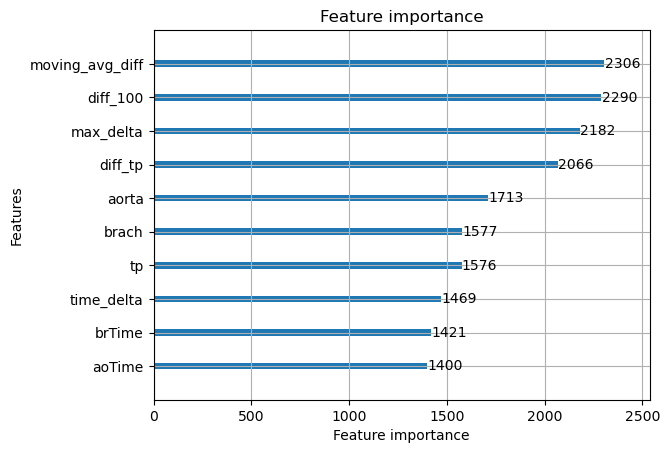

In [5]:
clf = LGBMClassifier()
clf.fit(train.drop("target", axis=1), train.target)
clf.score(test.drop("target", axis=1), test.target)
plot_importance(clf)

Text(0.5, 1.0, 'Top N Accuracy')

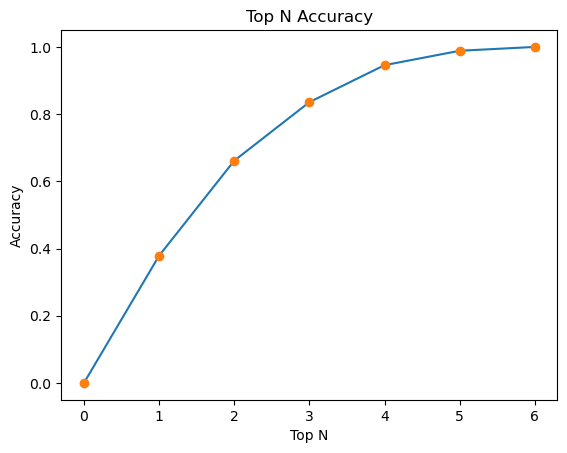

In [6]:
probs = clf.predict_proba(test.drop("target", axis=1))
sorts = np.argsort(-probs)
results = []
for n in range(7):
    score = np.mean([x[1] in x[0] for x in zip(sorts[:, 0:(n)], test.target)])
    results.append({
        'n': n,
        'score': score
    })

results_df = pd.DataFrame(results)

plt.plot(results_df['n'], results_df['score'])
plt.plot(results_df['n'], results_df['score'], 'o')
plt.xlabel('Top N')
plt.ylabel('Accuracy')
plt.title('Top N Accuracy')

In [7]:
final_clf = LGBMClassifier()
final_clf.fit(result_df.drop("target", axis=1), result_df.target)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1940
[LightGBM] [Info] Number of data points in the train set: 3499, number of used features: 10
[LightGBM] [Info] Start training from score -1.793762
[LightGBM] [Info] Start training from score -1.792045
[LightGBM] [Info] Start training from score -1.775038
[LightGBM] [Info] Start training from score -1.793762
[LightGBM] [Info] Start training from score -1.804125
[LightGBM] [Info] Start training from score -1.792045


LGBMClassifier()

In [8]:
final_test, _ = readInput('test')
final_result_df = summarize_moving_average_features(final_test)
final_result_df = final_result_df.set_index('id').join(summarize_raw_features(final_test))

100%|██████████| 875/875 [00:00<00:00, 3087.65it/s]


In [9]:
pd.Series(final_clf.predict(final_result_df), index=final_result_df.index).to_json('cama_submission/cama_output.json', indent=4)